# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

!pip install imageio
!pip install progressbar

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import pylab as plt
import time
import torch
import os

In [3]:
import progressbar as pb

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [4]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
agents_number = num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_dim = action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_dim = state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [7]:
import time
for i in range(1, 2):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        time.sleep(0.1)
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0


actions = [right_to_left, right_jump(threshold>0.5), left_to_right, left_to_jump]

When finished, you can close the environment.

env.close()

### Here's my result

In [8]:
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random

from collections import deque, namedtuple
from typing import Dict, List, Union,Tuple

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable


os.makedirs("./model_results", exist_ok=True)

In [10]:
def moving_average(a, n=100) :
    ret = np.cumsum(np.concatenate([np.zeros(n), a]))
    ret[n:] = ret[n:] - ret[:-n]
    n_arr = np.clip(np.arange(1, len(a)+1), 1, n)
    return ret[n:] / n_arr

In [11]:
def noise_injection(r, r0=0.015, n_max=1., n_min=0.005):
    if r <= 0: return n_max
    return np.clip(r0/np.sqrt(r), n_min, n_max)

In [12]:
class Task:
    def __init__(self, env, brain_name):
        self.env = env
        self.brain_name = brain_name
        self.reset()
        
        uniform = torch.distributions.Uniform(-1, 1)
        uniform._batch_shape = torch.Size([1, env.brains[brain_name].vector_action_space_size])
        
        self.action_space = uniform
        
    def reset(self, train_mode=True):
        out = self.env.reset(train_mode=train_mode)[brain_name]     # reset the environment
        return out.vector_observations.astype(np.float32)
    
    def step(self, action):
        out = env.step(action)[self.brain_name]
        state = out.vector_observations
        rewards = out.rewards
        done = out.local_done
        info = out.text_observations
        return (state, rewards, done, info)

In [13]:
task = Task(env, brain_name)
device = torch.device('cuda')

root_path = "saved_model"

In [14]:
from torch.utils.tensorboard import SummaryWriter
from maddpg import MADDPG

In [32]:
def seeding(seed=32167):
    #torch.backends.cudnn.deterministic = True
    #torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)

seeding()

In [33]:
writer = SummaryWriter('runs/p3_maddpg')

number_of_episodes = 4000
max_episode_length = 600
warmup_episodes = 20

noise = 1.0
noise_max, noise_min = 1., 0.005
noise_reduction = 0.996
noise_reset_episodes = 1000

episode_score_every = 50
save_interval = 200

config = {'batch_size': 500,
          'p_batch_size': 0,
          'n_batch_size': 0,
          'buffer_size': int(2e5),
          'number_updates': 1,
          'update_every_iterations': 1,
          'soft_update_every': 4,
          'critic_lr': 1e-3,
          'actor_lr': 1e-3,
          'actor_lr_decay': 0,
          'critic_lr_decay': 0,
          'actor_tau': 0.006,
          'critic_tau': 0.006,
          'warm_up': 1e3,
          'hidden_layers': (400, 300),
          'noise_scale': 1.2,
          'noise_sigma': .45,
          'agents_number': agents_number,
          'gradient_clip': 1.0,
          'discount': 0.99,
         }

maddpg = MADDPG(task, state_dim, action_dim, config, device, writer)
maddpg.reset()

all_rewards = np.zeros((number_of_episodes, agents_number))


In [34]:
print(maddpg.agents[0].actor)
print(maddpg.agents[0].critic)

ActorBody(
  (layers): ModuleList(
    (0): Linear(in_features=24, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=300, bias=True)
    (2): Linear(in_features=300, out_features=2, bias=True)
  )
)
CriticBody(
  (layers): ModuleList(
    (0): Linear(in_features=48, out_features=400, bias=True)
    (1): Linear(in_features=404, out_features=300, bias=True)
    (2): Linear(in_features=300, out_features=1, bias=True)
  )
)


<timed exec>:37: RuntimeWarning: Mean of empty slice.                        | 
/home/kretyn/courses/DeRL/venv/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<timed exec>:39: RuntimeWarning: Mean of empty slice.
<timed exec>:42: RuntimeWarning: Mean of empty slice.


State contains NaN. Skipping.
State contains NaN. Skipping.
State contains NaN. Skipping.
State contains NaN. Skipping.
State contains NaN. Skipping.
State contains NaN. Skipping.
State contains NaN. Skipping.
State contains NaN. Skipping.
State contains NaN. Skipping.
State contains NaN. Skipping.
State contains NaN. Skipping.
State contains NaN. Skipping.
State contains NaN. Skipping.
State contains NaN. Skipping.


Ep   49. Rewards (over last 100): Avg: 0.00776 | Max: 0.1  | Min: -0.01 | Noise max:    1.0


Ep   99. Rewards (over last 100): Avg: 0.00576 | Max: 0.1  | Min: -0.01 | Noise max:    1.0


Ep  149. Rewards (over last 100): Avg: 0.0019  | Max: 0.1  | Min: -0.01 | Noise max:    1.0


Ep  199. Rewards (over last 100): Avg: 0.0     | Max: 0.0  | Min: -0.01 | Noise max:    1.0


Ep  249. Rewards (over last 100): Avg: 0.0     | Max: 0.0  | Min: -0.01 | Noise max:    1.0


Ep  299. Rewards (over last 100): Avg: 0.0048  | Max: 0.1  | Min: -0.01 | Noise max:    1.0


Ep  349. Rewards (over last 100): Avg: 0.0078  | Max: 0.1  | Min: -0.01 | Noise max:    1.0


Ep  399. Rewards (over last 100): Avg: 0.0069  | Max: 0.1  | Min: -0.01 | Noise max:    1.0


Ep  449. Rewards (over last 100): Avg: 0.0127  | Max: 0.1  | Min: -0.01 | Noise max:    1.0


Ep  499. Rewards (over last 100): Avg: 0.0238  | Max: 0.1  | Min: -0.01 | Noise max:    1.0


Ep  549. Rewards (over last 100): Avg: 0.0349  | Max: 0.1  | Min: -0.01 | Noise max:  0.137


Ep  599. Rewards (over last 100): Avg: 0.0399  | Max: 0.1  | Min: -0.01 | Noise max:    1.0


Ep  649. Rewards (over last 100): Avg: 0.0356  | Max: 0.1  | Min: -0.01 | Noise max:  0.112


Ep  699. Rewards (over last 100): Avg: 0.0383  | Max: 0.2  | Min: -0.01 | Noise max:    1.0


Ep  749. Rewards (over last 100): Avg: 0.0405  | Max: 0.2  | Min: -0.01 | Noise max:  0.127


Ep  799. Rewards (over last 100): Avg: 0.0588  | Max: 0.2  | Min: -0.01 | Noise max: 0.0537


Ep  849. Rewards (over last 100): Avg: 0.0795  | Max: 0.2  | Min: -0.01 | Noise max:    1.0


Ep  899. Rewards (over last 100): Avg: 0.0651  | Max: 0.2  | Min: -0.01 | Noise max:    1.0


Ep  949. Rewards (over last 100): Avg: 0.0526  | Max: 0.19 | Min: -0.01 | Noise max:    1.0


Ep  999. Rewards (over last 100): Avg: 0.056   | Max: 0.19 | Min: -0.01 | Noise max:  0.112


Ep 1049. Rewards (over last 100): Avg: 0.0528  | Max: 0.1  | Min: -0.01 | Noise max:  0.137


Ep 1099. Rewards (over last 100): Avg: 0.058   | Max: 0.2  | Min: -0.01 | Noise max: 0.0658


Ep 1149. Rewards (over last 100): Avg: 0.0675  | Max: 0.2  | Min: -0.01 | Noise max:  0.075


Ep 1199. Rewards (over last 100): Avg: 0.0631  | Max: 0.3  | Min: -0.01 | Noise max: 0.0537


Ep 1249. Rewards (over last 100): Avg: 0.0613  | Max: 0.3  | Min: -0.02 | Noise max:    1.0


Ep 1299. Rewards (over last 100): Avg: 0.0585  | Max: 0.2  | Min: -0.02 | Noise max:  0.137


Ep 1349. Rewards (over last 100): Avg: 0.0631  | Max: 0.59 | Min: -0.01 | Noise max: 0.0658


Ep 1399. Rewards (over last 100): Avg: 0.0686  | Max: 0.59 | Min: -0.01 | Noise max:    1.0


Ep 1449. Rewards (over last 100): Avg: 0.0672  | Max: 0.3  | Min: -0.01 | Noise max: 0.0839


Ep 1499. Rewards (over last 100): Avg: 0.0758  | Max: 0.7  | Min: -0.01 | Noise max: 0.0567


Ep 1549. Rewards (over last 100): Avg: 0.0689  | Max: 0.7  | Min: -0.01 | Noise max:    1.0


Ep 1599. Rewards (over last 100): Avg: 0.0549  | Max: 0.29 | Min: -0.01 | Noise max:    1.0


Ep 1649. Rewards (over last 100): Avg: 0.0678  | Max: 0.4  | Min: -0.01 | Noise max:    1.0


Ep 1699. Rewards (over last 100): Avg: 0.0634  | Max: 0.4  | Min: -0.01 | Noise max:    1.0


Ep 1749. Rewards (over last 100): Avg: 0.0605  | Max: 0.6  | Min: -0.01 | Noise max: 0.0551


Ep 1799. Rewards (over last 100): Avg: 0.0763  | Max: 0.6  | Min: -0.01 | Noise max:  0.119


Ep 1849. Rewards (over last 100): Avg: 0.0693  | Max: 0.3  | Min: -0.01 | Noise max:  0.127


Ep 1899. Rewards (over last 100): Avg: 0.0708  | Max: 0.6  | Min: -0.01 | Noise max: 0.0658


Ep 1949. Rewards (over last 100): Avg: 0.0818  | Max: 0.6  | Min: -0.01 | Noise max:  0.119


Ep 1999. Rewards (over last 100): Avg: 0.0834  | Max: 1.0  | Min: -0.01 | Noise max: 0.0559


Ep 2049. Rewards (over last 100): Avg: 0.0727  | Max: 1.0  | Min: -0.01 | Noise max:  0.137


Ep 2099. Rewards (over last 100): Avg: 0.0616  | Max: 0.3  | Min: -0.01 | Noise max:  0.137


Ep 2149. Rewards (over last 100): Avg: 0.0948  | Max: 1.6  | Min: -0.01 | Noise max:    1.0


Ep 2199. Rewards (over last 100): Avg: 0.105   | Max: 1.6  | Min: -0.01 | Noise max: 0.0645


Ep 2249. Rewards (over last 100): Avg: 0.18    | Max: 1.6  | Min: -0.01 | Noise max:    1.0


Ep 2299. Rewards (over last 100): Avg: 0.346   | Max: 1.6  | Min: -0.01 | Noise max: 0.0413


Ep 2349. Rewards (over last 100): Avg: 0.387   | Max: 1.6  | Min: -0.01 | Noise max: 0.0342


Ep 2399. Rewards (over last 100): Avg: 0.3     | Max: 1.3  | Min: -0.01 | Noise max: 0.0362


Ep 2449. Rewards (over last 100): Avg: 0.385   | Max: 1.6  | Min: -0.01 | Noise max: 0.0218


Obtained the required value
CPU times: user 45min 50s, sys: 30.4 s, total: 46min 21s
Wall time: 47min 45s


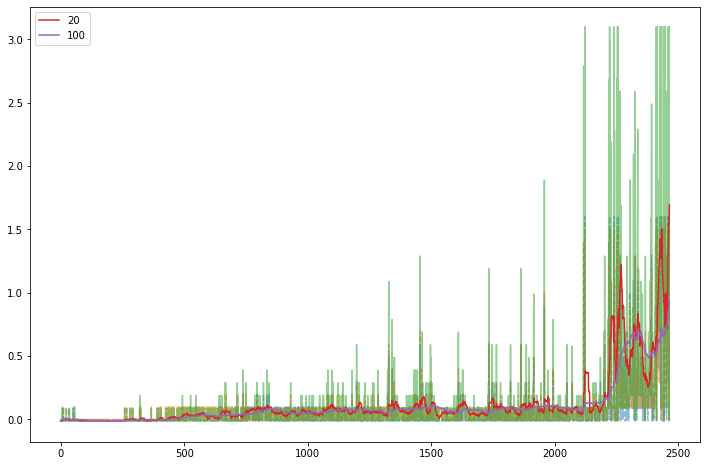

In [35]:
%%time
widget = ['episode: ', pb.Counter(),'/',str(number_of_episodes),' ', 
          pb.Percentage(), ' ', pb.ETA(), ' ', pb.Bar(marker=pb.RotatingMarker()), ' ' ]

timer = pb.ProgressBar(widgets=widget, maxval=number_of_episodes).start()
task.reset()

episode_reward = np.zeros(num_agents)
noise_arr = [noise]*agents_number

for episode in range(number_of_episodes):
    timer.update(episode)
    
    # Restart
    state = task.reset().flatten()
    episode_reward[:] = 0

    # SARS loop
    for frame_idx in range(max_episode_length):

        actions = maddpg.act(state, noise=noise_arr)
        actions = actions.detach().cpu().numpy().astype(np.float32).flatten()

        next_state, rewards, dones, info = task.step(actions)

        episode_reward += rewards
        next_state = next_state.flatten().astype(np.float32)

        maddpg.step(state, actions, rewards, next_state, dones)

        state = next_state.copy()
        
        if any(dones):
            break

    all_rewards[episode] = episode_reward
    _r = all_rewards[max(episode-100, 0):episode]
    avg_last_100 = np.max(_r, axis=1).mean()
    
    writer.add_scalars('rewards/avg100', {'game': _r.max(axis=1).mean(), 'agent0': _r[:,0].mean(), 'agent1': _r[:,1].mean()}, episode)
    writer.add_scalars('rewards/rewards', {'agent0': episode_reward[0], 'agent1': episode_reward[1]}, episode)

    noise_arr = [noise_injection(all_rewards[max(episode-5, 0):episode, agent].mean()) for agent in range(agents_number)]
    
    if (episode % episode_score_every) == (episode_score_every-1) or episode == number_of_episodes-1:
        print(f'Ep {episode:4}. Rewards (over last 100): Avg: {avg_last_100:<7.3} | Max: {np.max(_r):<4.2} | Min: {np.min(_r):4.2} | Noise max: {max(noise_arr):6.3}')
        
    if episode > 200 and (episode % 50 == 0) and np.max(all_rewards[episode-400:episode+1],axis=1).sum() <= 0.01:
        print("This is pointless. Breaking.")
        break

    #saving model
    if episode > 100 and avg_last_100 > 0.5:
        for agent_idx, agent in enumerate(maddpg.agents):
            torch.save(agent.actor.state_dict(), f"{root_path}/actor_{agent_idx}.net)")
            torch.save(agent.target_actor.state_dict(), f"{root_path}/target_actor_{agent_idx}.net")
            torch.save(agent.critic.state_dict(), f"{root_path}/critic_{agent_idx}.net)")
            torch.save(agent.target_critic.state_dict(), f"{root_path}/target_critic_{agent_idx}.net")
        
        print("Obtained the required value")
        break

timer.finish()

plt.figure(figsize=(12,8))
all_rewards_total = np.sum(all_rewards, axis=1)
plt.plot(all_rewards[:episode], '--', alpha=0.5)
plt.plot(all_rewards_total[:episode], alpha=0.5)
plt.plot(moving_average(all_rewards_total[:episode], 20), label='20')
plt.plot(moving_average(all_rewards_total[:episode]), label='100')
plt.legend()

## Analysis

### Actions in buffer

Graph below shows the first and last 2000 actions, top and bottom graphs respectively, from the buffer. In case the task hasn't finished before the buffer got full (num of actions above the buffer size) then this would represent some respetive time in the past.

The left column is a scatter plot of horizontal and vertical action values. This should show the most preferred actions taken by agents. It's expected that initially agents do random movements (random weights assignment and noise augmentation) and when the task is completed they have more structure.

The right column is a 2D line that connects all (for an agent) movements. The purpose is to show/detect whether there are any preferences in dynamics. It's expected that initially agent would do random movements thus covering a area related to the noise range, and by the end there would be more structure.

Text(0.5, 0.98, 'Total num actions 99738 | Color relates to agent')

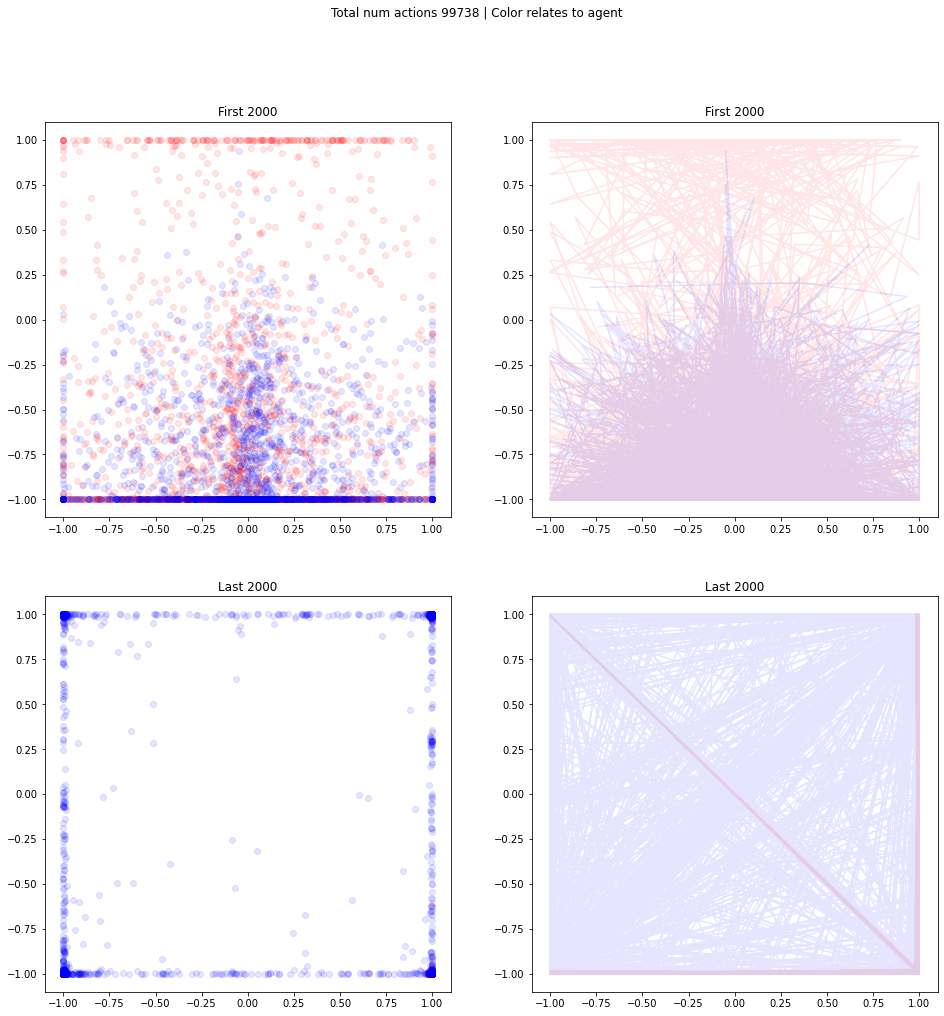

In [41]:
samples = maddpg.buffer.memory
all_actions = np.array([s[1] for s in samples])


fig, axes = plt.subplots(2,2, figsize=(16, 16))

actions = all_actions[:2000]
x1, y1 = actions[:, :2].reshape(2, -1)  # Red actions: right/left, jump
x2, y2 = actions[:, 2:].reshape(2, -1)  # Blue actions: left/right, jump

ax = axes[0][0]
ax.scatter(-x1, y1, color='r', alpha=0.1)
ax.scatter(x2, y2, color='b', alpha=0.1)
ax.set_title("First 2000")

ax = axes[0][1]
ax.plot(-x1, y1, color='r', alpha=0.1)
ax.plot(x2, y2, color='b', alpha=0.1)
ax.set_title("First 2000")

actions = all_actions[-2000:]
x1, y1 = actions[:, :2].reshape(2, -1)  # Red actions: right/left, jump
x2, y2 = actions[:, 2:].reshape(2, -1)  # Blue actions: left/right, jump
ax = axes[1][0]
ax.scatter(-x1, y1, color='r', alpha=0.1)
ax.scatter(x2, y2, color='b', alpha=0.1)
ax.set_title("Last 2000")

ax = axes[1][1]
ax.plot(-x1, y1, color='r', alpha=0.1)
ax.plot(x2, y2, color='b', alpha=0.1)
ax.set_title("Last 2000")


plt.suptitle(f"Total num actions {len(all_actions)} | Color relates to agent")

### Layers weights

#### Actor

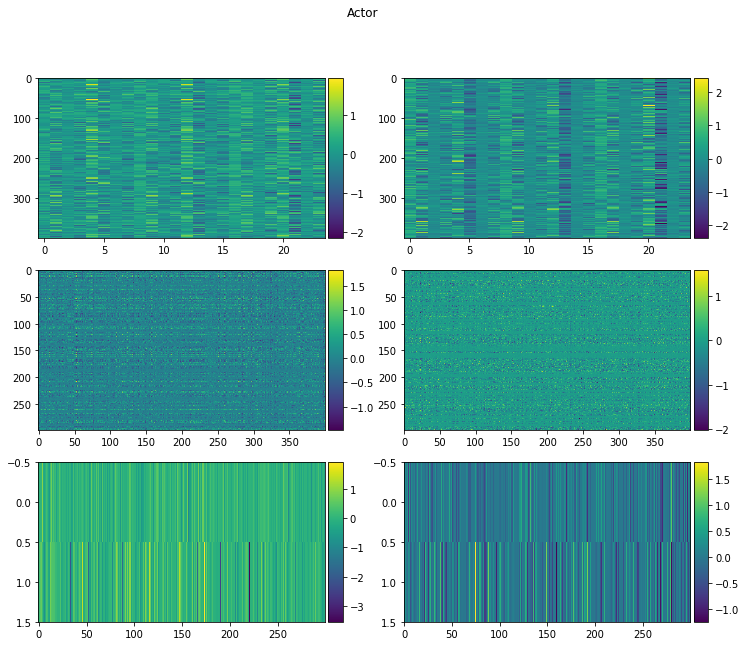

In [43]:
fig, axes = plt.subplots(len(layers), agents_number, figsize=(12,10))

for agent_idx, agent in enumerate(maddpg.agents):
    layers = agent.actor.layers

    for idx, layer in enumerate(layers):
        ax = axes[idx, agent_idx]
        divider = make_axes_locatable(ax)

        cax = divider.append_axes('right', size='5%', pad=0.05)
        im = ax.imshow(layer.weight.detach().cpu().numpy(), aspect='auto', interpolation='none')

        fig.colorbar(im, cax=cax, orientation='vertical')
    plt.suptitle("Actor")

#### Target actor

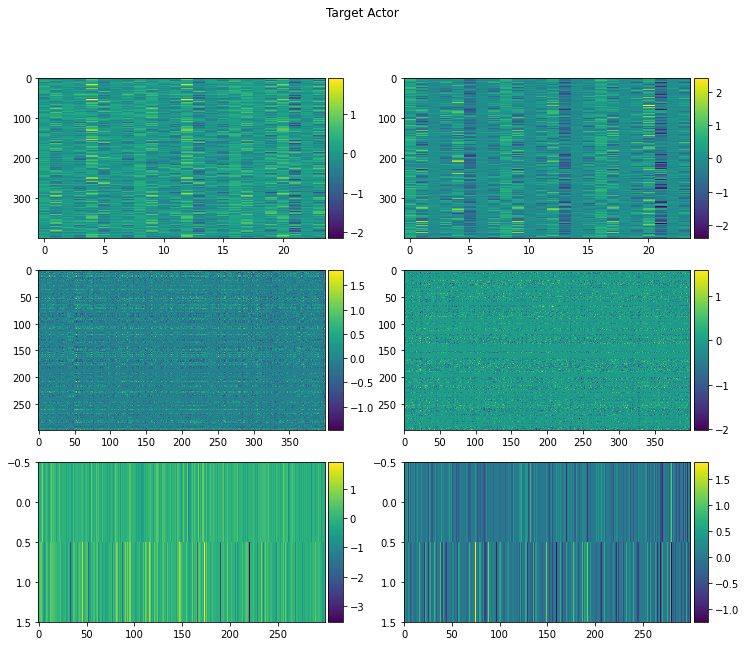

In [44]:
fig, axes = plt.subplots(len(layers), agents_number, figsize=(12,10))

for agent_idx, agent in enumerate(maddpg.agents):
    layers = agent.target_actor.layers

    for idx, layer in enumerate(layers):
        ax = axes[idx, agent_idx]
        divider = make_axes_locatable(ax)

        cax = divider.append_axes('right', size='5%', pad=0.05)
        im = ax.imshow(layer.weight.detach().cpu().numpy(), aspect='auto', interpolation='none')

        fig.colorbar(im, cax=cax, orientation='vertical')
    plt.suptitle("Target Actor")

#### Critic

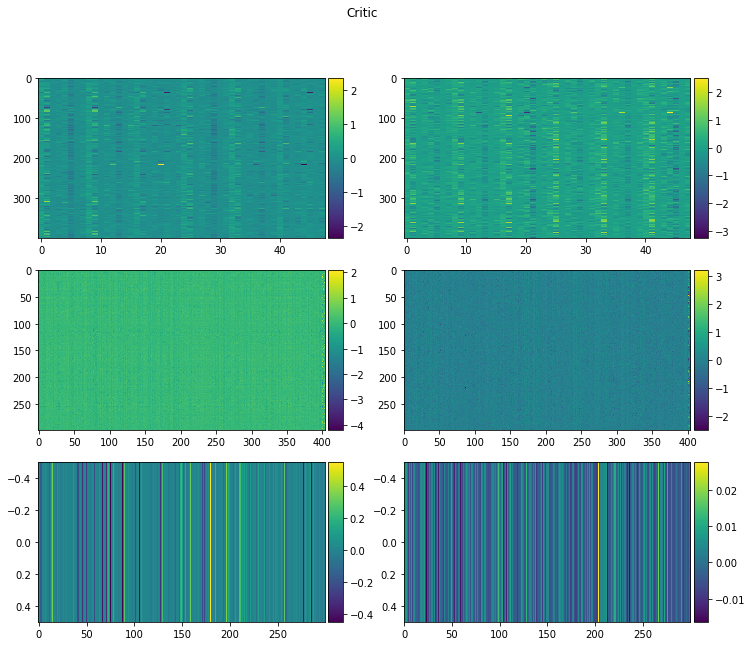

In [45]:
fig, axes = plt.subplots(len(layers), agents_number, figsize=(12,10))

for agent_idx, agent in enumerate(maddpg.agents):
    layers = agent.critic.layers

    for idx, layer in enumerate(layers):
        ax = axes[idx, agent_idx]
        divider = make_axes_locatable(ax)

        cax = divider.append_axes('right', size='5%', pad=0.05)
        im = ax.imshow(layer.weight.detach().cpu().numpy(), aspect='auto', interpolation='none')

        fig.colorbar(im, cax=cax, orientation='vertical')
    plt.suptitle("Critic")

#### Target critic

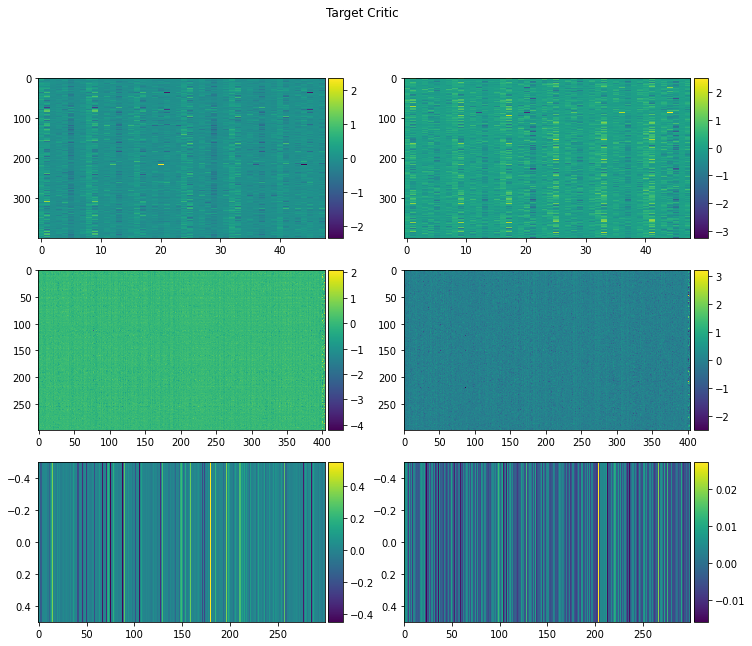

In [46]:
fig, axes = plt.subplots(len(layers), agents_number, figsize=(12,10))

for agent_idx, agent in enumerate(maddpg.agents):
    layers = agent.target_critic.layers

    for idx, layer in enumerate(layers):
        ax = axes[idx, agent_idx]
        divider = make_axes_locatable(ax)

        cax = divider.append_axes('right', size='5%', pad=0.05)
        im = ax.imshow(layer.weight.detach().cpu().numpy(), aspect='auto', interpolation='none')

        fig.colorbar(im, cax=cax, orientation='vertical')
    plt.suptitle("Target Critic")

# Testing model

In [39]:
root_path = 'saved_model'
loaded_maddpg = MADDPG(task, state_dim, action_dim, config, device, writer)

for agent_idx, agent in enumerate(loaded_maddpg.agents):
    agent.actor.load_state_dict(torch.load(f"{root_path}/actor_{agent_idx}.net)"))
    agent.target_actor.load_state_dict(torch.load(f"{root_path}/target_actor_{agent_idx}.net"))
    agent.critic.load_state_dict(torch.load(f"{root_path}/critic_{agent_idx}.net)"))
    agent.target_critic.load_state_dict(torch.load(f"{root_path}/target_critic_{agent_idx}.net"))

In [40]:
import time

for i in range(1, 5):
    states = task.reset(train_mode=False)
    scores = np.zeros(num_agents)
    while True:
        time.sleep(0.05)
        actions = loaded_maddpg.act(np.array(states, dtype=np.float32).flatten(), [noise_min]*agents_number)

        
        next_states, rewards, dones, info = task.step(actions.cpu().numpy().flatten())
        scores += rewards
        states = next_states
        if np.any(dones):
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 1.700000025331974
Score (max over agents) from episode 2: 0.9000000134110451
Score (max over agents) from episode 3: 2.0000000298023224
Score (max over agents) from episode 4: 1.5000000223517418
